# Calculate % recovery of ClinVar variants for each slopped refseq_exon file


### Tables not working with pybedtools. Search: possible data type issues
#### Workaround: import into R and resave to confirm dtypes, remove empty rows (why empty rows??)

In [46]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools
from pybedtools import BedTool

In [16]:
# specify the input bed files
exons_bed = '2019-10-30_RefSeq_mapped_exons_chromPROC.bed'
clinvar_bed = '2019-10-30_ClinVar_pathL.bed'

refseq_bedtool = pybedtools.BedTool(exons_bed)
cv_bedtool = pybedtools.BedTool(clinvar_bed)

# get required hg19 chromosome sizes
hg19_genome = pybedtools.helpers.get_chromsizes_from_ucsc(genome='hg19', saveas='hg19.genome')

In [17]:
# for every number in the interval 0, 5, 10, 15, .., 155 (non-inclusive) run slop adding that many bases to each end of regions
#sloplist = {}
for i in list(range(0, 155, 5)):
    fname = 'refseq_slop_{}.bed'.format(i)
    refseq_bedtool.slop(g=hg19_genome, b=i).saveas(os.path.join(cwd, fname))

In [18]:
cwd = os.getcwd()
print(cwd)

'/Users/pbousounis/Experiments/2010-10-29_hg19mod/2019-10-29_refseq-cv_recovery'

In [22]:
# define the not-element-of function to get regions unique to the test_bed file
def bed_not(ref_bed_filepath, test_bed_filepath):
    
    # specify the reference bed file
    ref_bedtool = BedTool(ref_bed_filepath)
    prfx_ref = ref_bed_filepath.split('/')[-1]
    prfx_ref = prfx_ref.split('.')[0]
    
    # specify the new ClinVar bed file
    test_bedtool = BedTool(test_bed_filepath)
    prfx_test = test_bed_filepath.split('/')[-1]
    prfx_test = prfx_test.split('.')[0]

    # specify name/path of output bed file
    out_bed_filepath = '{}/{}_NotIn_{}.bed'.format(cwd, prfx_test, prfx_ref)
    
    # run bedtools intersect to get all test_bed regions NOT found in ref_bed (-v option)
    ref_NotIn_test = test_bedtool.intersect(b=ref_bedtool, v=True)
    ref_NotIn_test.head()
    
    ref_NotIn_test.saveas(out_bed_filepath, trackline="track name='ClinVar loci NOT IN TSO bed file'")
    feat_count = ref_NotIn_test.count()
    
    # confirm file saved
    print('\nNumber of {} features NOT IN {} = {}'.format(prfx_test, prfx_ref, feat_count))
    
    if os.path.exists(out_bed_filepath):
        print('Success! File saved to {}.'.format(os.path.join(cwd, out_bed_filepath)))

    return(feat_count)

In [37]:
slop_files = glob.glob('{}/refseq_slop*.bed'.format(os.getcwd()))

mydict = {}
for i in slop_files:
    tmp = i.split('/')[-1]
    name = tmp.split('.')[0]
    fname = '{}_vs_ClinVar.bed'.format(name)
    slop_num = int(''.join(filter(str.isdigit, name))) 
    mydict[slop_num]= bed_not(i, clinvar_bed)

chr1	949522	949523	183381_ISG15
 chr1	949695	949696	161455_ISG15
 chr1	949738	949739	161454_ISG15
 chr1	957604	957605	243036_AGRN
 chr1	957692	957693	243037_AGRN
 chr1	976717	976718	654128_AGRN
 chr1	976733	976734	574478_AGRN
 chr1	976938	976939	654968_AGRN
 chr1	976961	976962	126556_AGRN
 chr1	977432	977433	644955_AGRN
 
Number of 2019-10-30_ClinVar_pathL features NOT IN refseq_slop_15 = 82096
Success! File saved to /Users/pbousounis/Experiments/2010-10-29_hg19mod/2019-10-29_refseq-cv_recovery/2019-10-30_ClinVar_pathL_NotIn_refseq_slop_15.bed.
chr1	949522	949523	183381_ISG15
 chr1	949695	949696	161455_ISG15
 chr1	949738	949739	161454_ISG15
 chr1	957604	957605	243036_AGRN
 chr1	957692	957693	243037_AGRN
 chr1	976717	976718	654128_AGRN
 chr1	976733	976734	574478_AGRN
 chr1	976938	976939	654968_AGRN
 chr1	976961	976962	126556_AGRN
 chr1	977432	977433	644955_AGRN
 
Number of 2019-10-30_ClinVar_pathL features NOT IN refseq_slop_120 = 81875
Success! File saved to /Users/pbousounis/Experimen

In [38]:
mydict

{15: 82096,
 120: 81875,
 135: 81831,
 10: 82125,
 125: 81863,
 130: 81845,
 75: 82005,
 0: 82870,
 140: 81812,
 60: 82028,
 70: 82013,
 5: 82170,
 145: 81790,
 150: 81770,
 65: 82020,
 40: 82060,
 55: 82038,
 80: 81997,
 95: 81966,
 85: 81982,
 90: 81975,
 45: 82052,
 50: 82043,
 20: 82090,
 115: 81892,
 100: 81948,
 35: 82061,
 25: 82079,
 110: 81913,
 105: 81929,
 30: 82069}

In [40]:
# reformat dictionary and convert to dataframe
slop_num = []
cv_not_tso = []
for x in mydict:
    slop_num.append(x)
    cv_not_tso.append(mydict[x])

newdict = {
    'region_slop':slop_num, 'clinvar_NOT_recovered':cv_not_tso
}

slop_df = pd.DataFrame.from_dict(newdict)
slop_df.region_slop = pd.to_numeric(slop_df.region_slop, errors='coerce')
df = slop_df.sort_values(by = ['region_slop']).reset_index()
del df['index']

# view the DataFrame
df

,region_slop,clinvar_NOT_recovered
0,0,82870
1,5,82170
2,10,82125
3,15,82096
4,20,82090
5,25,82079
6,30,82069
7,35,82061
8,40,82060
9,45,82052


In [41]:
# save the clinvar vs refseq slop dataframe

file_out = '2019-10-30_ClinVar_NotIn_refseqSlops.tsv'
df.to_csv(file_out, sep = '\t', index=False)

if os.path.exists(file_out):
    print('Success! File saved to {}.'.format(os.path.join(cwd, file_out)))

Success! File saved to /Users/pbousounis/Experiments/2010-10-29_hg19mod/2019-10-29_refseq-cv_recovery/2019-10-30_ClinVar_NotIn_refseqSlops.tsv.


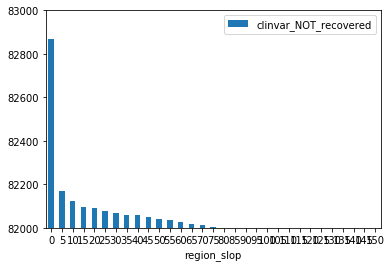

In [52]:
# Plot the data
df.plot.bar(x='region_slop', y='clinvar_NOT_recovered', rot = 0, ylim=(82000, 83000)) 